In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## LOAD DATA


In [48]:
from util.load_scenarios import load_scenario_df
from util.load_evaluations import load_evaluation_df

eval_df = load_evaluation_df("../data/evaluation/benchmarking/default")
scenario_df = load_scenario_df("../data/definition/routes_devtest_sliced.xml")

# join scenario and evaluation data
df = eval_df.join(scenario_df, on='route_index', how='inner').sort_index()

## PROCESS DATA


In [49]:
# drop infractions data
df = df.loc[:, ~df.columns.str.startswith('infractions')]

### Label fidelity robustness


In [50]:

safe_threshold = 0.01
risky_threshold = 0.25

df.loc[:, 'label'] = np.select(
    [df['driving_score_error'] < safe_threshold,
     df['driving_score_error'].between(safe_threshold, risky_threshold),
     df['driving_score_error'] > risky_threshold,
     ],
    ['safe', 'moderate', 'risky',],
)

## VISUALISE


## Old plot for RQ1


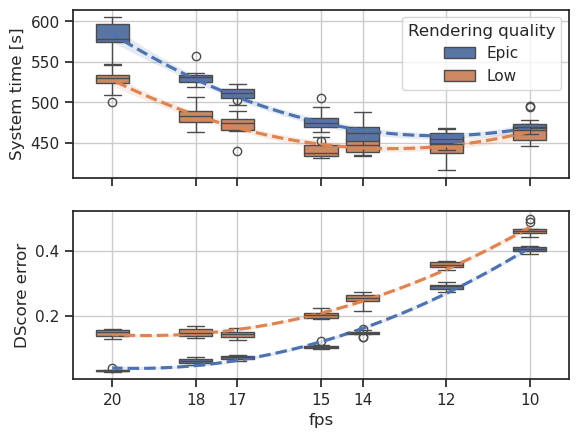

In [51]:
def new_boxplot(agg, ax, col='driving_score_error'):

    epicq = agg.xs("True", level='highquality',
                   drop_level=False).reset_index()
    lowq = agg.xs("False", level='highquality',
                  drop_level=False).reset_index()

    ax = sns.boxplot(lowq, x='fps', y=col, hue='highquality', ax=ax, native_scale=True, hue_order=["True", "False"]
                     )

    ax = sns.boxplot(epicq, x='fps', y=col,
                     hue='highquality', ax=ax,  native_scale=True, hue_order=["True", "False"])

    ax = sns.regplot(epicq, x='fps', y=col, ax=ax,
                     order=2, scatter=False, line_kws=dict(linestyle='dashed'),)

    ax = sns.regplot(lowq, x='fps', y=col, ax=ax,  order=2,
                     scatter=False, line_kws=dict(linestyle='dashed'),)


def make_boxplots(df):

    agg = df[['driving_score_error', 'duration_system']].groupby(
        ['fps', 'highquality', "rep"]).mean()

    vals = set(agg.reset_index()['fps'].values)

    sns.set_theme(style="ticks", palette="deep")
    f, axes = plt.subplots(nrows=2, sharex=True,)
    axes[0].invert_xaxis()

    axes[0].set_ylabel(f"System time [s]")
    new_boxplot(agg, ax=axes[0], col='duration_system')
    axes[0].grid()
    axes[0].set_xticks(list(vals))
    axes[0].set_ylabel(f"System time [s]")

    new_boxplot(agg, ax=axes[1], col='driving_score_error')
    axes[1].get_legend().remove()
    axes[1].grid()
    axes[1].set_ylabel(f"DScore error")

    handles, _ = axes[0].get_legend_handles_labels()

    axes[0].legend(handles=handles, labels=["Epic", "Low"],
                   title="Rendering quality")

    # f.savefig('plot_rq12.pdf', bbox_inches='tight')


make_boxplots(df)

### Are low fid benefictial for safe scenarios


In [52]:

safe_df = df[df['label'] == 'safe']
agg = safe_df[['driving_score_error', 'duration_system']].groupby(
    ['fps', 'highquality', "rep"]).mean()

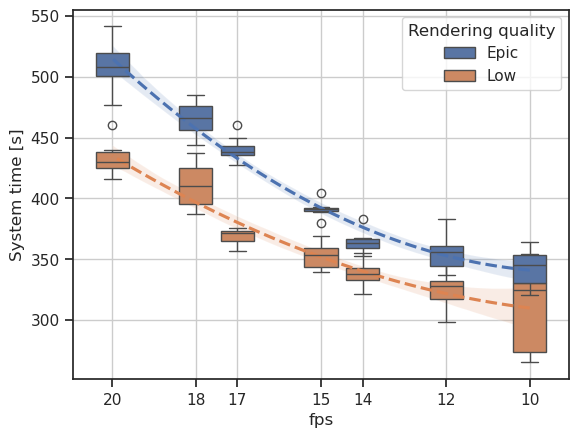

In [53]:

vals = set(agg.reset_index()['fps'].values)

# sns.set_theme(style="ticks", palette="deep")
f, axes = plt.subplots(nrows=1, sharex=True,)
axes.invert_xaxis()

axes.set_ylabel(f"System time [s]")
new_boxplot(agg, ax=axes, col='duration_system')
axes.grid()
axes.set_xticks(list(vals))
axes.set_ylabel(f"System time [s]")


handles, _ = axes.get_legend_handles_labels()

axes.legend(handles=handles, labels=["Epic", "Low"],
            title="Rendering quality")